# Homework 10 Assignment 2 for PUI2016
**Name:** Cheng Hou

**NetID:** ch3019

---

# Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data for different seasons using pysal and geopandas
## Import initial libraries

In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

## Working with Shape File
### Loading Census Tract Shape File

In [2]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations

In [3]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

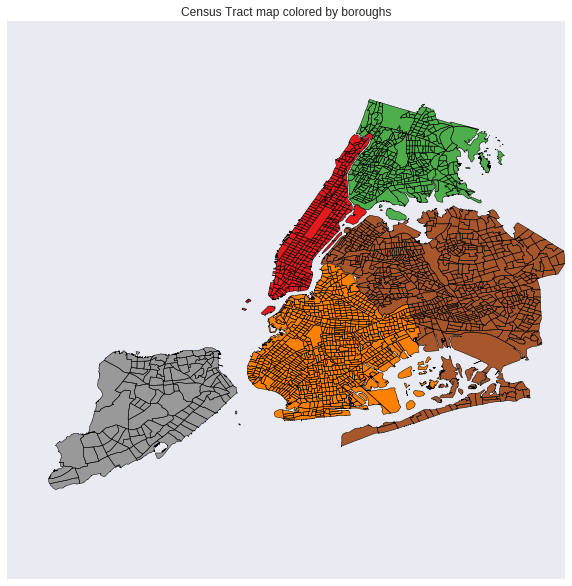

In [4]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha=1, linewidth=0.5, ax=ax)
plt.title("Census Tract map colored by boroughs")
plt.show()

### Map NYC Population density
#### Load Census Data for 2010

In [5]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']])

#### Vusualize the Population density for 2010

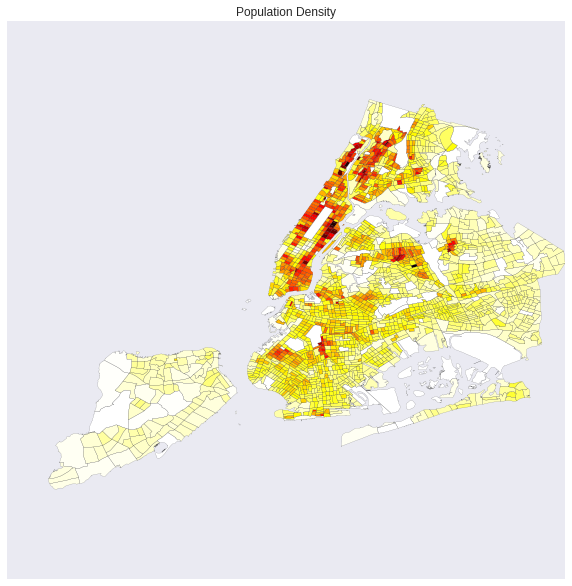

In [7]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002', cmap='hot_r', alpha=1, linewidth=0.1, ax=ax)
plt.title("Population Density")
plt.show()

## Explore CitiBike data
### Load CitiBike data

In [8]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Separate the CitiBike data by different seasons:
+  **Summer:** Mar,Apr,May
  
+  **Winter:** Dec,Jan,Feb

In [9]:
df_bike_monthly_summer = df_bike_monthly[np.in1d(df_bike_monthly.index.month, [6,7,8])]
df_bike_monthly_winter = df_bike_monthly[np.in1d(df_bike_monthly.index.month, [12,1,2])]

### Time Series Aanalysis

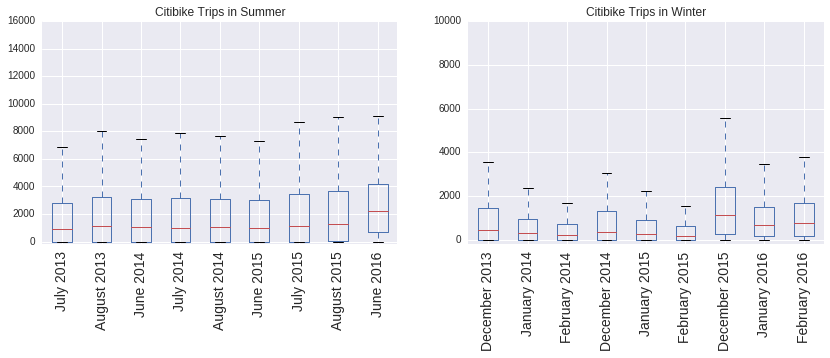

In [10]:
plt.rcParams['font.size'] = 14
f, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))

df_bike_monthly_summer_ = df_bike_monthly_summer.copy()
df_bike_monthly_summer_.index = df_bike_monthly_summer_.index.strftime("%B %Y")
df_bike_monthly_summer_.T.boxplot(figsize=(15,7), ax=ax1, rot=90, return_type='axes');
ax1.set_ylim([-200,16000])
ax1.set_title('Citibike Trips in Summer')

df_bike_monthly_winter_ = df_bike_monthly_winter.copy()
df_bike_monthly_winter_.index = df_bike_monthly_winter_.index.strftime("%B %Y")
df_bike_monthly_winter_.T.boxplot(figsize=(15,7), ax=ax2, rot=90, return_type='axes');
ax2.set_ylim([-200,10000])
ax2.set_title('Citibike Trips in Winter')

plt.show()

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


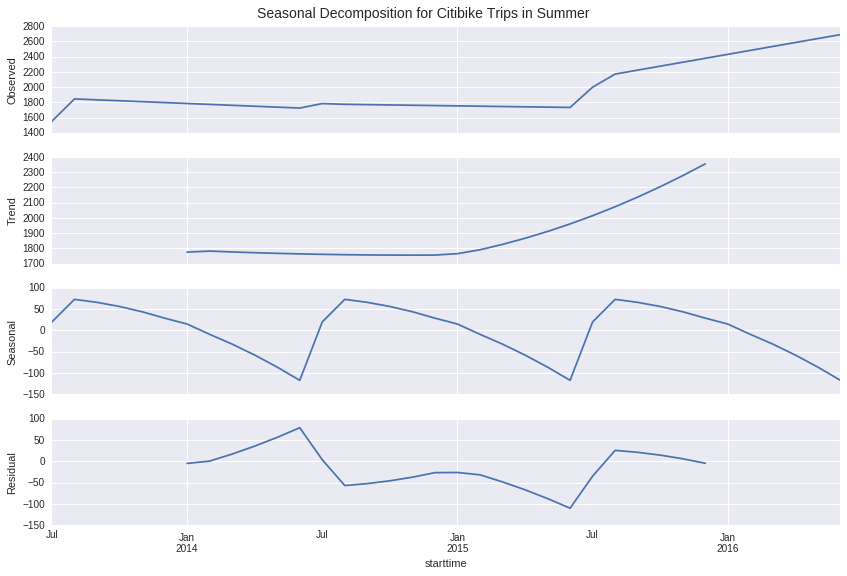

In [11]:
plt.rcParams['figure.figsize'] = (12,8)
df_new_summer = df_bike_monthly_summer.mean(1).resample('M').mean()
df_new_summer.interpolate(inplace=True)
res_summer = sm.tsa.seasonal_decompose(df_new_summer.dropna())
resplot_summer = res_summer.plot()
plt.suptitle('Seasonal Decomposition for Citibike Trips in Summer', y=1)

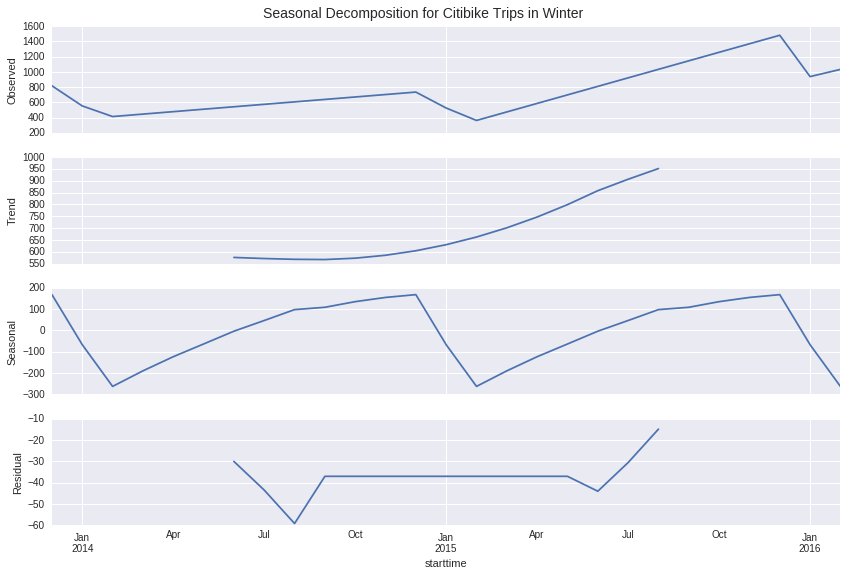

In [12]:
plt.rcParams['figure.figsize'] = (12,8)
df_new_winter = df_bike_monthly_winter.mean(1).resample('M').mean()
df_new_winter.interpolate(inplace=True)
res_winter = sm.tsa.seasonal_decompose(df_new_winter.dropna())
resplot_winter = res_winter.plot()
plt.suptitle('Seasonal Decomposition for Citibike Trips in Winter', y=1)

## Map CitiBike Data to CT level
### Load CitiBike station location data

In [13]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
station_id.index = station_id.index.astype(str)
station_id.head(3)

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [14]:
station_id['lonlat']=zip(station_id.lon,station_id.lat)
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head(3)

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)


### Intersect the two geometries

In [15]:
ct_shape.head(3)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...


In [16]:
a=[]
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [18]:
station_id['MonthlyAve_summer']=df_bike_monthly_summer.sum()
station_id['MonthlyAve_winter']=df_bike_monthly_winter.sum()
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve_summer,MonthlyAve_winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,21889


### Add the monthly average rides to the CT shapefile 

In [19]:
temp = station_id[['MonthlyAve_summer', 'MonthlyAve_winter']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0, inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


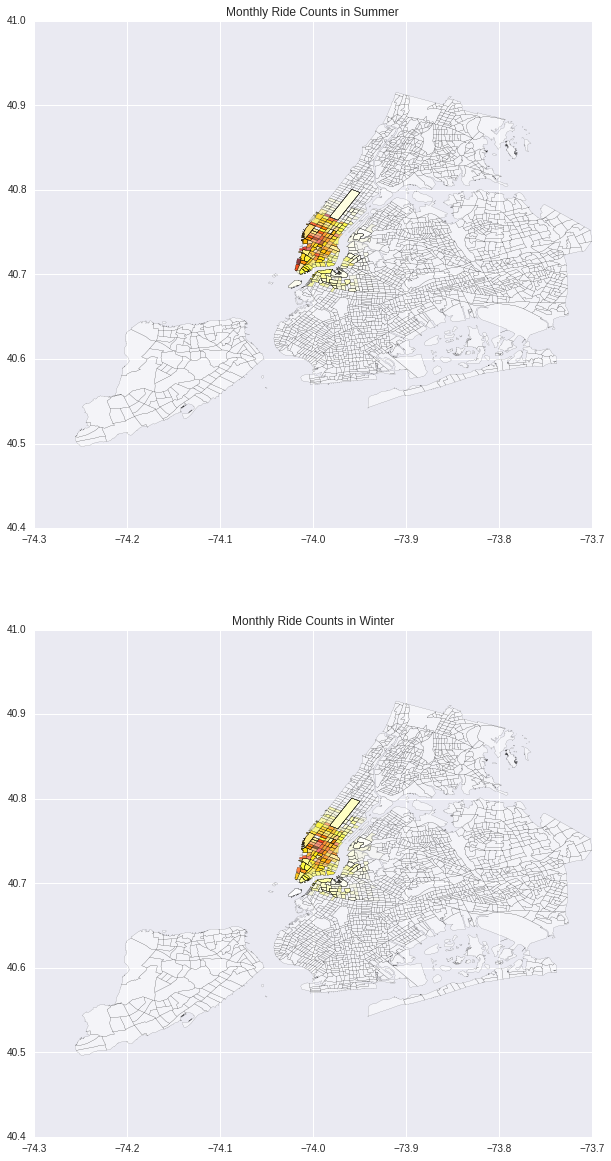

In [20]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ct_shape_MonthlyAve.plot(column='MonthlyAve_summer', cmap='hot_r', linewidth=0.1, ax=ax1)
ct_shape_MonthlyAve.plot(column='MonthlyAve_winter', cmap='hot_r', linewidth=0.1, ax=ax2)
ax1.set_title("Monthly Ride Counts in Summer")
ax2.set_title("Monthly Ride Counts in Winter")
plt.show()

### Removing the CTs that are out of zoom boundries

In [21]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [22]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(ct_shape_MonthlyAve_Zoom)

Total number of CTs: 2166
Number of zoomed CTs: 796


### Map the monthly rides

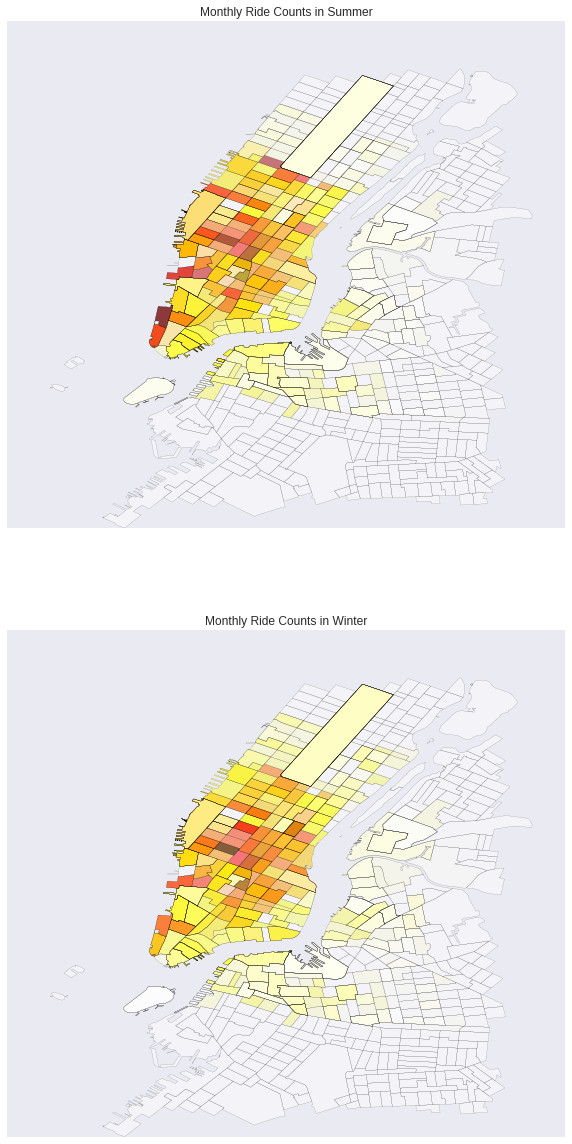

In [23]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve_summer', cmap='hot_r', linewidth=0.1, ax=ax1)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve_winter', cmap='hot_r', linewidth=0.1, ax=ax2)
ax1.set_title("Monthly Ride Counts in Summer")
ax2.set_title("Monthly Ride Counts in Winter")
plt.show()

### Export Shapefile CTs in the CitiBike Zone

In [37]:
path='Output/ct_shape_MonthlyAve_Zoom_2.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis
### Spatial Weights
Contiguity: Queen Weights

In [25]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Matrix of Weights

In [26]:
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [27]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [28]:
MonthlyRide_summer = ct_shape_MonthlyAve_Zoom.MonthlyAve_summer
MonthlyRideLag_summer = ps.lag_spatial(qW_CT, MonthlyRide_summer)
MonthlyRide_winter = ct_shape_MonthlyAve_Zoom.MonthlyAve_winter
MonthlyRideLag_winter = ps.lag_spatial(qW_CT, MonthlyRide_winter)

#### Create Quantiles for maping

In [29]:
MonthlyRideLagQ10_summer = ps.Quantiles(MonthlyRideLag_summer, k=10)
print MonthlyRideLagQ10_summer
MonthlyRideLagQ10_winter = ps.Quantiles(MonthlyRideLag_winter, k=10)
print MonthlyRideLagQ10_winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80
                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237       

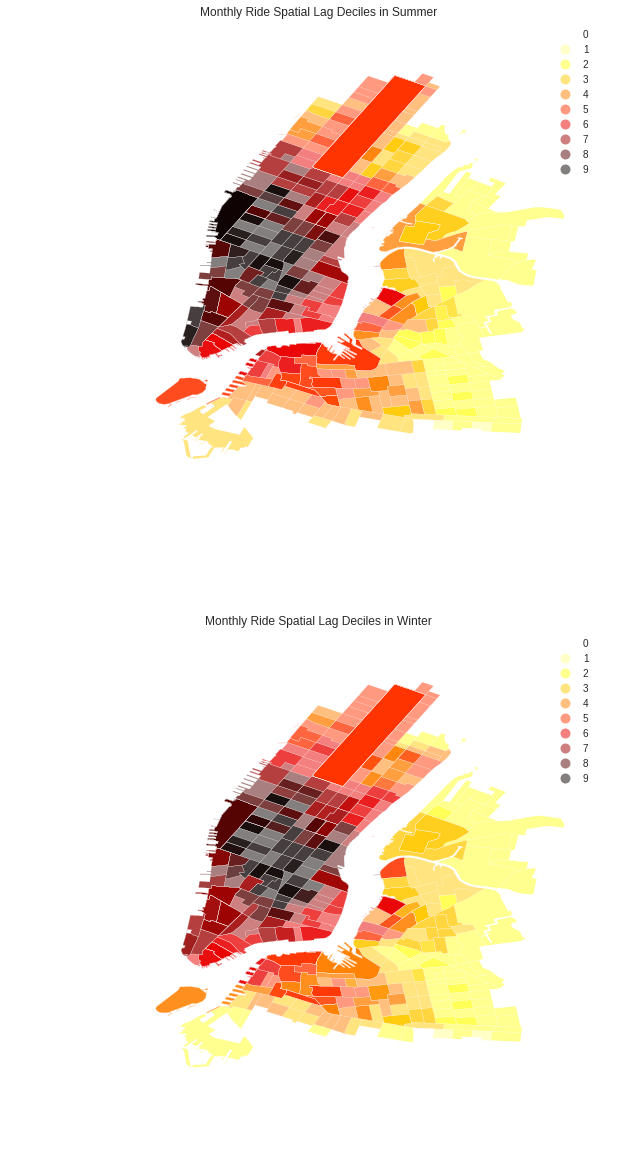

In [30]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ct_shape_MonthlyAve_Zoom.assign(cls=MonthlyRideLagQ10_summer.yb).plot(column='cls', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_MonthlyAve_Zoom.assign(clw=MonthlyRideLagQ10_winter.yb).plot(column='clw', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("Monthly Ride Spatial Lag Deciles in Summer")
ax2.set_title("Monthly Ride Spatial Lag Deciles in Winter")
plt.show()

## Global Spatial Autocorrelation

In [31]:
sb,sa = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
print ("Summer :\n ({} , {})".format(sb, sa))
wb,wa = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
print ("Winter :\n ({} , {})".format(wb, wa))

Summer :
 (0.643354908154 , 4220.55529808)
Winter :
 (0.660232498582 , 1600.83242387)


### Moran Scatterplot

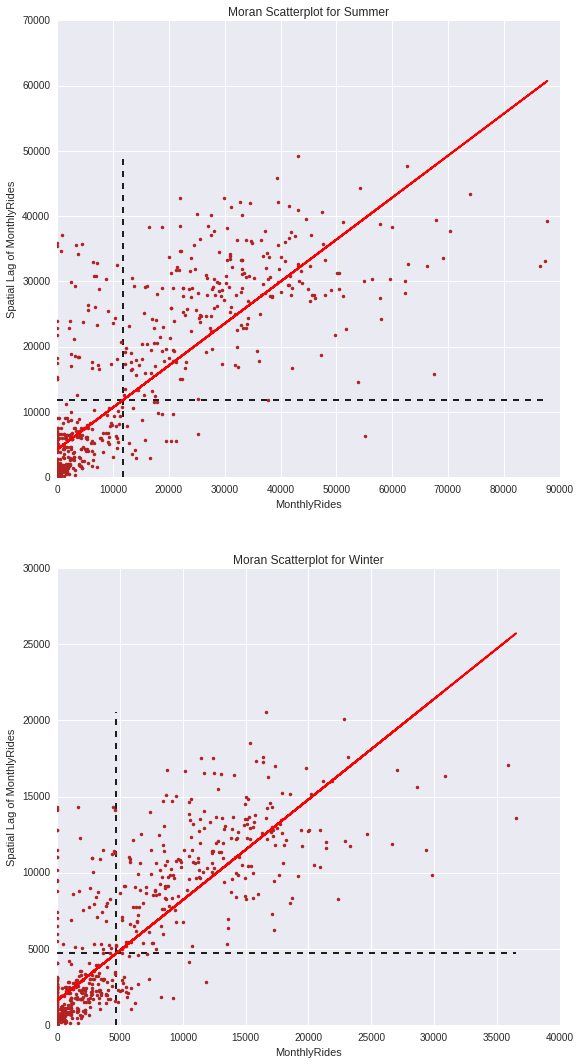

In [32]:
fig = plt.figure(figsize=(9,18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')
ax1.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
ax1.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')
ax1.plot(MonthlyRide_summer, sa + sb*MonthlyRide_summer, 'r')
ax1.set_title('Moran Scatterplot for Summer')
ax1.set_ylabel('Spatial Lag of MonthlyRides')
ax1.set_xlabel('MonthlyRides')

ax2.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')
ax2.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
ax2.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')
ax2.plot(MonthlyRide_winter, wa + wb*MonthlyRide_winter, 'r')
ax2.set_title('Moran Scatterplot for Winter')
ax2.set_ylabel('Spatial Lag of MonthlyRides')
ax2.set_xlabel('MonthlyRides')

plt.show()

### Moran's I

In [33]:
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT)
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT)
print ("Summer :\n ({} , {})".format(I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim))
print ("Winter :\n ({} , {})".format(I_MonthlyRide_winter.I, I_MonthlyRide_winter.p_sim))

Summer :
 (0.64353398667 , 0.001)
Winter :
 (0.660391564319 , 0.001)


### KDEplot of all of the simulated points
the vertical line shows the observed value

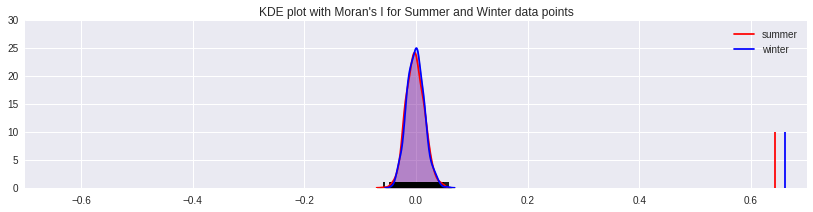

In [34]:
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True, color='r')
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.I, 0, 10, 'r', label='summer')
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True, color='b')
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.I, 0, 10, 'b', label='winter')
plt.xlim([-.70, .70])
plt.legend()
plt.title('KDE plot with Moran\'s I for Summer and Winter data points')
plt.show()

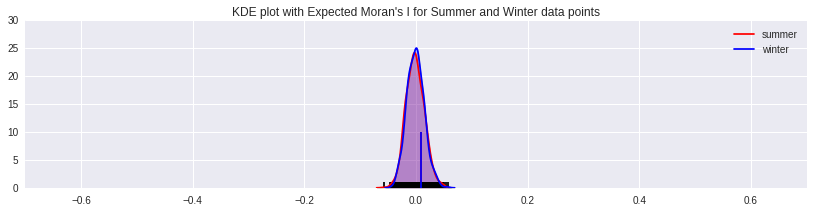

In [35]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True, color='r')
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.EI+0.01, 0, 10, 'r', label='summer')
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True, color='b')
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.EI+0.01, 0, 10, 'b', label='winter')
plt.xlim([-.70, .70])
plt.legend()
plt.title('KDE plot with Expected Moran\'s I for Summer and Winter data points')
plt.show()

## Local Spatial Autocorrelation

In [36]:
LMo_MonthlyRide_summer = ps.Moran_Local(MonthlyRide_summer, qW_CT, permutations=999)
LMo_MonthlyRide_winter = ps.Moran_Local(MonthlyRide_winter, qW_CT, permutations=999)

### LISA (Local Indicators of Spatial Autocorrelation)

In [38]:
sigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim <= .001]
insigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim > .001]

sigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim <= .001]
insigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim > .001]

### Plot Signficant LISA

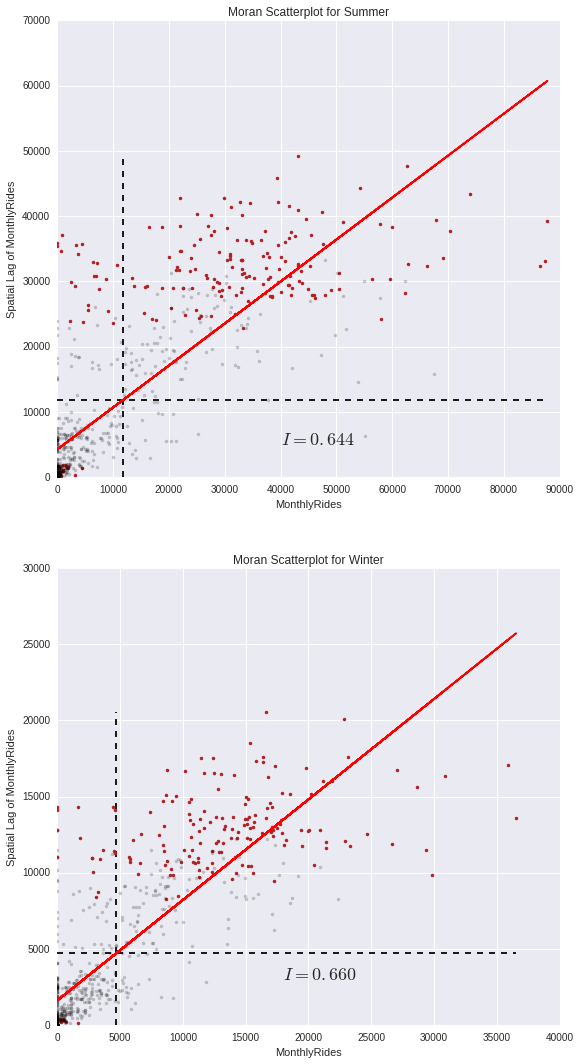

In [45]:
fig = plt.figure(figsize=(9,18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
ax1.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
ax1.text(s='$I = %.3f$' % I_MonthlyRide_summer.I, x=40000, y=5000, fontsize=18)
ax1.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
ax1.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')
ax1.plot(MonthlyRide_summer, sa + sb*MonthlyRide_summer, 'r')
ax1.set_title('Moran Scatterplot for Summer')
ax1.set_ylabel('Spatial Lag of MonthlyRides')
ax1.set_xlabel('MonthlyRides')

ax2.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
ax2.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
ax2.text(s='$I = %.3f$' % I_MonthlyRide_winter.I, x=18000, y=3000, fontsize=18)
ax2.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
ax2.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')
ax2.plot(MonthlyRide_winter, wa + wb*MonthlyRide_winter, 'r')
ax2.set_title('Moran Scatterplot for Winter')
ax2.set_ylabel('Spatial Lag of MonthlyRides')
ax2.set_xlabel('MonthlyRides')

plt.show()

### Hot and Cold spots

In [46]:
sig_summer = LMo_MonthlyRide_summer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRide_summer.q == 1 * sig_summer
coldspots_summer = LMo_MonthlyRide_summer.q == 3 * sig_summer
print "Number of Hotspots for Summer:", hotspots_summer.sum()
print "Number of Coldspots for Summer:", coldspots_summer.sum()

sig_winter = LMo_MonthlyRide_winter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRide_winter.q == 1 * sig_winter
coldspots_winter = LMo_MonthlyRide_winter.q == 3 * sig_winter
print "Number of Hotspots for Winter:", hotspots_winter.sum()
print "Number of Coldspots for Winter:", coldspots_winter.sum()

Number of Hotspots for Summer: 186
Number of Coldspots for Summer: 243
Number of Hotspots for Winter: 191
Number of Coldspots for Winter: 206


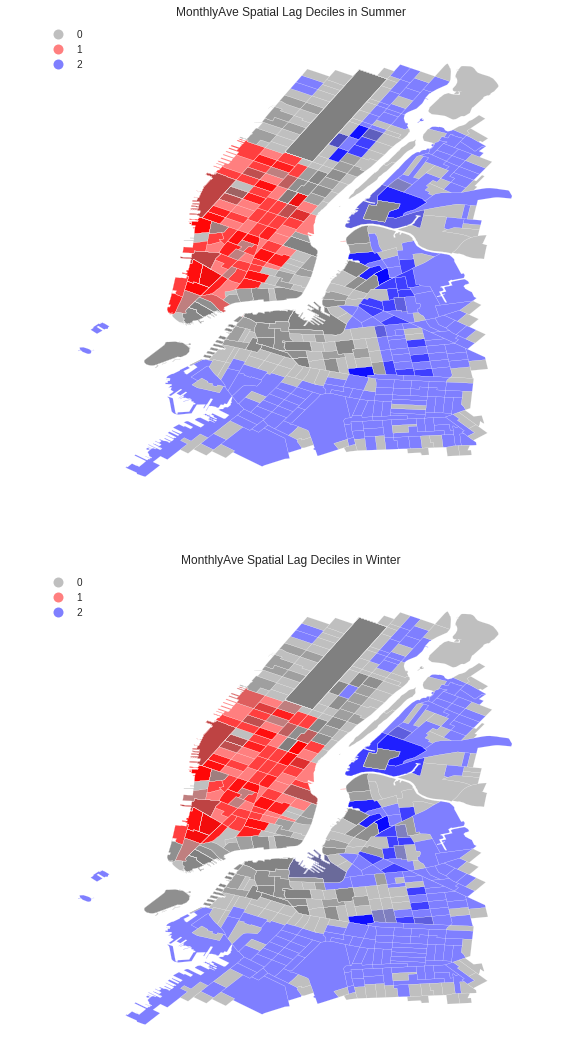

In [48]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

fig = plt.figure(figsize=(9,18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ct_shape_MonthlyAve_Zoom.assign(cls2=hotcold_summer).plot(column='cls2', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_MonthlyAve_Zoom.assign(clw2=hotcold_winter).plot(column='clw2', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("MonthlyAve Spatial Lag Deciles in Summer")
ax2.set_title("MonthlyAve Spatial Lag Deciles in Winter")
plt.show()